# Group Project
#### **FINN43815 - Python for Finance**

In [164]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import kurtosis, skew
import yfinance as yf
from matplotlib import pyplot as plt

### Volume Trading Strategy

#### 1. Import Data

In [165]:
data = pd.read_csv('cleaned_data.csv')

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_26976/1299969751.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



In [166]:
# drop unnecessary columns
data = data[["date", "permno", "price", "volume"]]
data

,date,permno,price,volume
0,1990-01-31,0111145D UN Equity,20.6875,49200.0
1,1990-02-28,0111145D UN Equity,22.0000,141600.0
2,1990-03-30,0111145D UN Equity,19.5000,32400.0
3,1990-04-30,0111145D UN Equity,17.6250,219400.0
4,1990-05-31,0111145D UN Equity,19.8125,128800.0
...,...,...,...,...
514691,2022-04-29,J UN Equity,138.5500,304510.0
514692,2022-05-31,J UN Equity,140.0900,439716.0
514693,2022-06-30,J UN Equity,127.1300,361201.0
514694,2022-07-29,J UN Equity,137.3000,214654.0


#### 2. Calculate monthly returns

In [167]:
data['rets'] = data.groupby('permno')['price'].transform(pd.Series.pct_change)
data.head()

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_26976/1728035520.py:1: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.



,date,permno,price,volume,rets
0,1990-01-31,0111145D UN Equity,20.6875,49200.0,NaN
1,1990-02-28,0111145D UN Equity,22.0000,141600.0,0.063444
2,1990-03-30,0111145D UN Equity,19.5000,32400.0,-0.113636
3,1990-04-30,0111145D UN Equity,17.6250,219400.0,-0.096154
4,1990-05-31,0111145D UN Equity,19.8125,128800.0,0.124113


#### 3. Calculate On-Balance Volume (OBV)

In [168]:
OBV = [0]
for _, df in data.groupby("permno"):
    for i in range(1, len(df.price)):
        if df["price"].iloc[i] > df["price"].iloc[i-1]:
            OBV += [OBV[i-1] + df["volume"].iloc[i]]
        elif df["price"].iloc[i] < df["price"].iloc[i-1]:
            OBV += [OBV[i-1] - df["volume"].iloc[i]]
        else:
            OBV += [OBV[i-1]]

In [169]:
data = data.dropna().reset_index(drop=True)

In [170]:
data.loc[:,"pt-1"] = data.groupby("permno").price.shift(1)
data.loc[:,"signal"] = np.where(data.price > data["pt-1"], 1, 0)
data.loc[:,"signal"] = np.where(data["pt-1"] > data.price, -1, data.signal)

In [171]:
data.loc[:,"vol"] = data.volume * data.signal
data

,date,permno,price,volume,rets,pt-1,signal,vol
0,1990-02-28,0111145D UN Equity,22.0000,141600.0,0.063444,NaN,0,0.0
1,1990-03-30,0111145D UN Equity,19.5000,32400.0,-0.113636,22.0000,-1,-32400.0
2,1990-04-30,0111145D UN Equity,17.6250,219400.0,-0.096154,19.5000,-1,-219400.0
3,1990-05-31,0111145D UN Equity,19.8125,128800.0,0.124113,17.6250,1,128800.0
4,1990-06-29,0111145D UN Equity,18.9375,32200.0,-0.044164,19.8125,-1,-32200.0
...,...,...,...,...,...,...,...,...
297922,2022-04-29,J UN Equity,138.5500,304510.0,0.005370,137.8100,1,304510.0
297923,2022-05-31,J UN Equity,140.0900,439716.0,0.011115,138.5500,1,439716.0
297924,2022-06-30,J UN Equity,127.1300,361201.0,-0.092512,140.0900,-1,-361201.0
297925,2022-07-29,J UN Equity,137.3000,214654.0,0.079997,127.1300,1,214654.0


In [172]:
data.loc[:,"OBV"] = data.groupby("permno")["vol"].cumsum()

In [173]:
data = data.drop(columns=["pt-1", "signal", "vol"])

In [174]:
data[data.permno=="J UN Equity"]

,date,permno,price,volume,rets,OBV
297536,1990-02-28,J UN Equity,2.3125,150400.0,0.156250,0.0
297537,1990-03-30,J UN Equity,2.5156,561600.0,0.087827,561600.0
297538,1990-04-30,J UN Equity,2.3906,373600.0,-0.049690,188000.0
297539,1990-05-31,J UN Equity,3.1094,55200.0,0.300678,243200.0
297540,1990-06-29,J UN Equity,2.9375,84800.0,-0.055284,158400.0
...,...,...,...,...,...,...
297922,2022-04-29,J UN Equity,138.5500,304510.0,0.005370,11288256.0
297923,2022-05-31,J UN Equity,140.0900,439716.0,0.011115,11727972.0
297924,2022-06-30,J UN Equity,127.1300,361201.0,-0.092512,11366771.0
297925,2022-07-29,J UN Equity,137.3000,214654.0,0.079997,11581425.0


#### 4. Calculate Exponential Moving Average

In [175]:
data["OBV_ewm"] = data.groupby("permno")["OBV"].ewm(span=15).mean().reset_index(drop=True)

In [176]:
for x,y in data.groupby("permno"):
    if x == "0111145D UN Equity":
        print(y.OBV.ewm(span=15).mean())

0      0.000000e+00
1     -1.728000e+04
2     -1.060923e+05
3     -1.111995e+05
4     -1.224912e+05
           ...     
257    3.486527e+06
258    3.505459e+06
259    3.495196e+06
260    3.499708e+06
261    3.477330e+06
Name: OBV, Length: 262, dtype: float64


In [177]:
data[data.permno =="0111145D UN Equity"]

,date,permno,price,volume,rets,OBV,OBV_ewm
0,1990-02-28,0111145D UN Equity,22.0000,141600.0,0.063444,0.0,0.000000e+00
1,1990-03-30,0111145D UN Equity,19.5000,32400.0,-0.113636,-32400.0,-1.728000e+04
2,1990-04-30,0111145D UN Equity,17.6250,219400.0,-0.096154,-251800.0,-1.060923e+05
3,1990-05-31,0111145D UN Equity,19.8125,128800.0,0.124113,-123000.0,-1.111995e+05
4,1990-06-29,0111145D UN Equity,18.9375,32200.0,-0.044164,-155200.0,-1.224912e+05
...,...,...,...,...,...,...,...
257,2011-07-29,0111145D UN Equity,54.7000,126900.0,-0.000731,3507166.0,3.486527e+06
258,2011-08-31,0111145D UN Equity,55.6000,130817.0,0.016453,3637983.0,3.505459e+06
259,2011-09-30,0111145D UN Equity,55.0100,214629.0,-0.010612,3423354.0,3.495196e+06
260,2011-10-31,0111145D UN Equity,56.2500,107938.0,0.022541,3531292.0,3.499708e+06


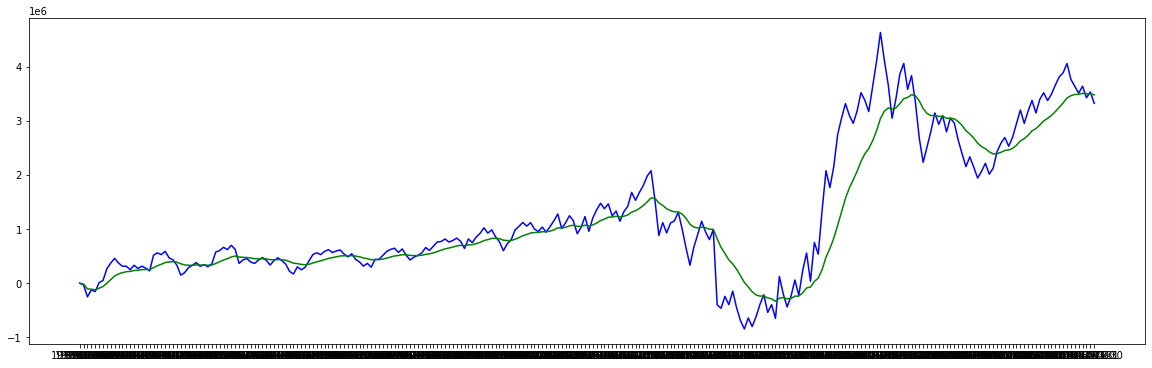

In [178]:
plt.figure(figsize=(20, 6))
plt.plot(data[data.permno=="0111145D UN Equity"].date, data[data.permno=="0111145D UN Equity"].OBV, color="blue")
plt.plot(data[data.permno=="0111145D UN Equity"].date, data[data.permno=="0111145D UN Equity"].OBV_ewm, color="green")

In [179]:
data["signal"] = np.where(data.OBV > data.OBV_ewm, 1, 0)

In [180]:
data[data.permno=="0111145D UN Equity"]

,date,permno,price,volume,rets,OBV,OBV_ewm,signal
0,1990-02-28,0111145D UN Equity,22.0000,141600.0,0.063444,0.0,0.000000e+00,0
1,1990-03-30,0111145D UN Equity,19.5000,32400.0,-0.113636,-32400.0,-1.728000e+04,0
2,1990-04-30,0111145D UN Equity,17.6250,219400.0,-0.096154,-251800.0,-1.060923e+05,0
3,1990-05-31,0111145D UN Equity,19.8125,128800.0,0.124113,-123000.0,-1.111995e+05,0
4,1990-06-29,0111145D UN Equity,18.9375,32200.0,-0.044164,-155200.0,-1.224912e+05,0
...,...,...,...,...,...,...,...,...
257,2011-07-29,0111145D UN Equity,54.7000,126900.0,-0.000731,3507166.0,3.486527e+06,1
258,2011-08-31,0111145D UN Equity,55.6000,130817.0,0.016453,3637983.0,3.505459e+06,1
259,2011-09-30,0111145D UN Equity,55.0100,214629.0,-0.010612,3423354.0,3.495196e+06,0
260,2011-10-31,0111145D UN Equity,56.2500,107938.0,0.022541,3531292.0,3.499708e+06,1


#### 5. Get Trading Signals

In [181]:
data.loc[:,"position"] = data.groupby("permno")["signal"].diff()
data
# position = 1 -> buy
# position = -1 -> sell

,date,permno,price,volume,rets,OBV,OBV_ewm,signal,position
0,1990-02-28,0111145D UN Equity,22.0000,141600.0,0.063444,0.0,0.000000e+00,0,NaN
1,1990-03-30,0111145D UN Equity,19.5000,32400.0,-0.113636,-32400.0,-1.728000e+04,0,0.0
2,1990-04-30,0111145D UN Equity,17.6250,219400.0,-0.096154,-251800.0,-1.060923e+05,0,0.0
3,1990-05-31,0111145D UN Equity,19.8125,128800.0,0.124113,-123000.0,-1.111995e+05,0,0.0
4,1990-06-29,0111145D UN Equity,18.9375,32200.0,-0.044164,-155200.0,-1.224912e+05,0,0.0
...,...,...,...,...,...,...,...,...,...
297922,2022-04-29,J UN Equity,138.5500,304510.0,0.005370,11288256.0,2.636634e+07,0,0.0
297923,2022-05-31,J UN Equity,140.0900,439716.0,0.011115,11727972.0,2.607408e+07,0,0.0
297924,2022-06-30,J UN Equity,127.1300,361201.0,-0.092512,11366771.0,2.594201e+07,0,0.0
297925,2022-07-29,J UN Equity,137.3000,214654.0,0.079997,11581425.0,2.592299e+07,0,0.0


In [182]:
# shift position (trading decision) by two days
data.loc[:,"position"] = data.groupby("permno")["position"].shift(2)

In [183]:
data

,date,permno,price,volume,rets,OBV,OBV_ewm,signal,position
0,1990-02-28,0111145D UN Equity,22.0000,141600.0,0.063444,0.0,0.000000e+00,0,NaN
1,1990-03-30,0111145D UN Equity,19.5000,32400.0,-0.113636,-32400.0,-1.728000e+04,0,NaN
2,1990-04-30,0111145D UN Equity,17.6250,219400.0,-0.096154,-251800.0,-1.060923e+05,0,NaN
3,1990-05-31,0111145D UN Equity,19.8125,128800.0,0.124113,-123000.0,-1.111995e+05,0,0.0
4,1990-06-29,0111145D UN Equity,18.9375,32200.0,-0.044164,-155200.0,-1.224912e+05,0,0.0
...,...,...,...,...,...,...,...,...,...
297922,2022-04-29,J UN Equity,138.5500,304510.0,0.005370,11288256.0,2.636634e+07,0,0.0
297923,2022-05-31,J UN Equity,140.0900,439716.0,0.011115,11727972.0,2.607408e+07,0,0.0
297924,2022-06-30,J UN Equity,127.1300,361201.0,-0.092512,11366771.0,2.594201e+07,0,0.0
297925,2022-07-29,J UN Equity,137.3000,214654.0,0.079997,11581425.0,2.592299e+07,0,0.0


#### 6. Get Returns of Trading Strategy

In [184]:
# get returns for strategy
data["vol_rets"] = data.groupby("permno")["signal"].shift(2) * data.rets

In [185]:
strategy_returns = data.groupby("date")["vol_rets"].mean().reset_index()

In [186]:
strategy_returns.date = pd.to_datetime(strategy_returns.date)

In [187]:
strategy_returns = strategy_returns.dropna()

In [188]:
strategy_returns["vol_cum_rets"] = (strategy_returns.vol_rets +1).cumprod()

### Evaluation

In [189]:
px.line(strategy_returns, y='vol_cum_rets', x='date', labels={'vol_cum_rets': 'Cumulative returns'}, title = 'OBV Returns').show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [190]:
px.histogram(strategy_returns[['vol_rets']]).show()

In [191]:
monthly_rets = strategy_returns[["date", "vol_rets"]].resample('M', on='date').mean() # Calculate average daily return for each month
monthly_rets['Colour']='red' # Add column with 'red' value
monthly_rets.loc[monthly_rets['vol_rets']>=0, 'Colour']='green' # Replace 'red' with 'green' where return is non-negative
px.bar(monthly_rets,x=monthly_rets.index,y="vol_rets").update_traces(marker_color=monthly_rets["Colour"]).show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [192]:
# mean and volatility
mean_ret = strategy_returns['vol_rets'].mean()
volatility = strategy_returns['vol_rets'].std()
print(mean_ret, volatility)

0.006043966023173701 0.025173054561218742


In [193]:
print('Annualised expected return is: '+str(round(100*mean_ret*12,2)) +'%')
print('Annualised volatility is: '+str(round(100*volatility*np.sqrt(12),2)) +'%')

Annualised expected return is: 7.25%
Annualised volatility is: 8.72%


In [194]:
# describing statistic of returns
(strategy_returns['vol_rets']*100).describe()

count    389.000000
mean       0.604397
std        2.517305
min      -11.452665
25%       -0.745314
50%        0.791440
75%        2.047626
max        9.705493
Name: vol_rets, dtype: float64

In [195]:
# skewness
print(skew(strategy_returns['vol_rets'].dropna()))

-0.5935241489215107


In [196]:
# kurtosis
print(kurtosis(strategy_returns["vol_rets"].dropna()))

2.8828767173410457


In [197]:
# Value at Risk
VaR = strategy_returns['vol_rets'].quantile(0.005)
VaR

-0.09180692721865255

In [198]:
for q in [0.1, 0.05, 0.01, 0.001, 0.0001]:
    VaR = strategy_returns['vol_rets'].quantile(q)
    print('There is a '+str(round(100*q,3))+'% chance that my losses will be '+str(round(VaR*100, 2))+'% or worse over the next day.')

There is a 10.0% chance that my losses will be -2.26% or worse over the next day.
There is a 5.0% chance that my losses will be -3.76% or worse over the next day.
There is a 1.0% chance that my losses will be -6.05% or worse over the next day.
There is a 0.1% chance that my losses will be -11.01% or worse over the next day.
There is a 0.01% chance that my losses will be -11.41% or worse over the next day.


In [199]:
VaR = strategy_returns['vol_rets'].quantile(0.005)
rets_tail = strategy_returns.loc[strategy_returns['vol_rets']<=VaR,["date", "vol_rets", "vol_cum_rets"]]
rets_tail

,date,vol_rets,vol_cum_rets
224,2008-10-31,-0.103107,3.123473
361,2020-03-31,-0.114527,6.279013


In [200]:
ES = rets_tail['vol_rets'].mean()
ES

-0.10881690576535323

In [201]:
for q in [0.1, 0.05, 0.01, 0.001, 0.0001]:
    VaR = strategy_returns['vol_rets'].quantile(q)
    rets_tail = strategy_returns.loc[strategy_returns['vol_rets']<=VaR,:]
    ES = rets_tail['vol_rets'].mean()
    print('I expect to lose on average '+ str(round(ES*100, 2))+'% over 1-day period given that I have exceeded my VaR for '+str(round(100*q,3))+'%.')

I expect to lose on average -4.31% over 1-day period given that I have exceeded my VaR for 10.0%.
I expect to lose on average -5.64% over 1-day period given that I have exceeded my VaR for 5.0%.
I expect to lose on average -9.3% over 1-day period given that I have exceeded my VaR for 1.0%.
I expect to lose on average -11.45% over 1-day period given that I have exceeded my VaR for 0.1%.
I expect to lose on average -11.45% over 1-day period given that I have exceeded my VaR for 0.01%.


In [202]:
# according to bloomberg the risk free rate (treasury yields) 4.76 % (last 30 years)
# calculation of sharpe ratio

rf = 0.0476
sharpe_ratio = (mean_ret-rf)/volatility
sharpe_ratio

-1.650814122527941

In [203]:
# get SP500 data from 1990-01-31 to 2022-08-30	
sp500_ticker = yf.Ticker("^GSPC")
sp500 = sp500_ticker.history(start="1990-02-28", end="2022-09-30", interval="1mo")
sp500 = sp500[["Close"]]
sp500["Rets"] = sp500.Close.pct_change()

In [204]:
sp500

,Close,Rets
Date,,
1990-03-01 00:00:00-05:00,339.940002,NaN
1990-04-01 00:00:00-05:00,330.799988,-0.026887
1990-05-01 00:00:00-04:00,361.230011,0.091989
1990-06-01 00:00:00-04:00,358.019989,-0.008886
1990-07-01 00:00:00-04:00,356.149994,-0.005223
...,...,...
2022-05-01 00:00:00-04:00,4132.149902,0.000053
2022-06-01 00:00:00-04:00,3785.379883,-0.083920
2022-07-01 00:00:00-04:00,4130.290039,0.091116


In [205]:
# Calculate the average return of the market
average_market_return = sp500.Rets.mean()

# Calculate the covariance between portfolio and market returns
covariance = strategy_returns['vol_rets'].cov(sp500['Rets'].reset_index(drop=True))

# Calculate the variance of the market returns
market_variance = sp500['Rets'].var()

# Calculate the portfolio's beta
portfolio_beta = covariance / market_variance

# Calculate Jensen's Alpha
jensens_alpha = mean_ret - (rf + portfolio_beta * (average_market_return - rf))

print("Portfolio Beta:", portfolio_beta)
print("Jensen's Alpha:", jensens_alpha)

Portfolio Beta: -0.0037173724630780707
Jensen's Alpha: -0.041707007013215495


In [206]:
# treynor ratio
treynor_ratio = (mean_ret - rf)/portfolio_beta
treynor_ratio

11.178872816639132

In [207]:
# maximum drawdown
peak = strategy_returns.reset_index(drop=True).loc[1, "vol_cum_rets"]
max_drawdown = 0
for ret in strategy_returns["vol_cum_rets"].dropna():
    if ret >= peak:
        peak = ret
    else:
        drawdown = (peak - ret)/peak
        max_drawdown = max(max_drawdown, drawdown)

print(max_drawdown)

0.28951015746234604


In [208]:
# calmar-ratio
annualised_exp_return = round(mean_ret*12,2)
calmar_ratio = (annualised_exp_return - rf)/max_drawdown
calmar_ratio

0.07737206941664342